###  Assignment5:


*  I have reused Resnet20 DNN example code from keras examples link,  trained model for 50 epochs on CIFAR10 data set and have got validation accuracy as 84.2%. <br>

*  Have identified 50 misclassifed Images and have created Image gallary. <br>

*  Have implemented gradCAM, feed these mis-classified images and have created gradiang class activation map image gallary. . <br>


Ref: https://keras.io/examples/cifar10_resnet/

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True


In [32]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
print(model_type)



ResNet20v1


In [33]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)




x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)




In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr



In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x



In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [38]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 16)   64          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_normalization_20[0][0]     
_______________________________________________________________________________________

In [39]:
# Mount google drive to store check point model results.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
#filepath = os.path.join(save_dir, model_name)

from keras.callbacks import ModelCheckpoint

# Specify gdrive path to where highest validation accuracy check point results to be stored.
import os 
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/eip3_session5_cifar10_resnet18.hdf5"

# Create checkpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,monitor='val_loss', mode='min', period=1, verbose=1)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [55]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test), steps_per_epoch=(x_train.shape[0]/batch_size),
                        epochs=epochs, verbose=1, workers=4, callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.001
391/390 [==============================] - 30s 76ms/step - loss: 1.0363 - acc: 0.6869 - val_loss: 1.1161 - val_acc: 0.6544

Epoch 00001: val_loss improved from 1.32473 to 1.11612, saving model to /content/gdrive/My Drive/Colab Notebooks/eip3_session5_cifar10_resnet18.hdf5
Epoch 2/50
Learning rate:  0.001
391/390 [==============================] - 29s 75ms/step - loss: 0.9408 - acc: 0.7186 - val_loss: 1.5059 - val_acc: 0.5790

Epoch 00002: val_loss did not improve from 1.11612
Epoch 3/50
Learning rate:  0.001
391/390 [==============================] - 29s 74ms/step - loss: 0.8737 - acc: 0.7457 - val_loss: 1.1721 - val_acc: 0.6529

Epoch 00003: val_loss did not improve from 1.11612
Epoch 4/50
Learning rate:  0.001
391/390 [==============================] - 29s 74ms/step - loss: 0.8236 - acc: 0.7645 - val_loss: 0.8625 - val_acc: 0.7488

Epoch 00004: val_loss improved from 1.11612 to 0.86251, saving model to /content/gdriv

In [56]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 180us/step
Test loss: 0.6418683449268341
Test accuracy: 0.852


### To find out 50 misclassified images from the validation dataset 

In [185]:
y_pred = model.predict(x_test)
incorect_images = ([np.argmax(y_test[i])==np.argmax(y_pred[i]) for i in range(10000)])
incorrect_img_idx = list()
idx = 0
for i in range(10000):
  if (not incorect_images[i] ):
    incorrect_img_idx.append(i)
    idx = idx +1
print("Total number of Incorrect Images:%d out of %d"%(len(incorrect_img_idx), y_test.shape[0]))
  
incorrect_imgs_50 = incorrect_img_idx[0:50]


Total number of Incorrect Images:1480 out of 10000


W0702 14:47:26.303651 140244150687616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 14:47:26.314786 140244150687616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 14:47:26.326581 140244150687616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 14:47:26.337434 140244150687616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 14:47:26.349317 140244150687616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 14:47:26.363255 140244150687616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 14:47:26.378742 140244

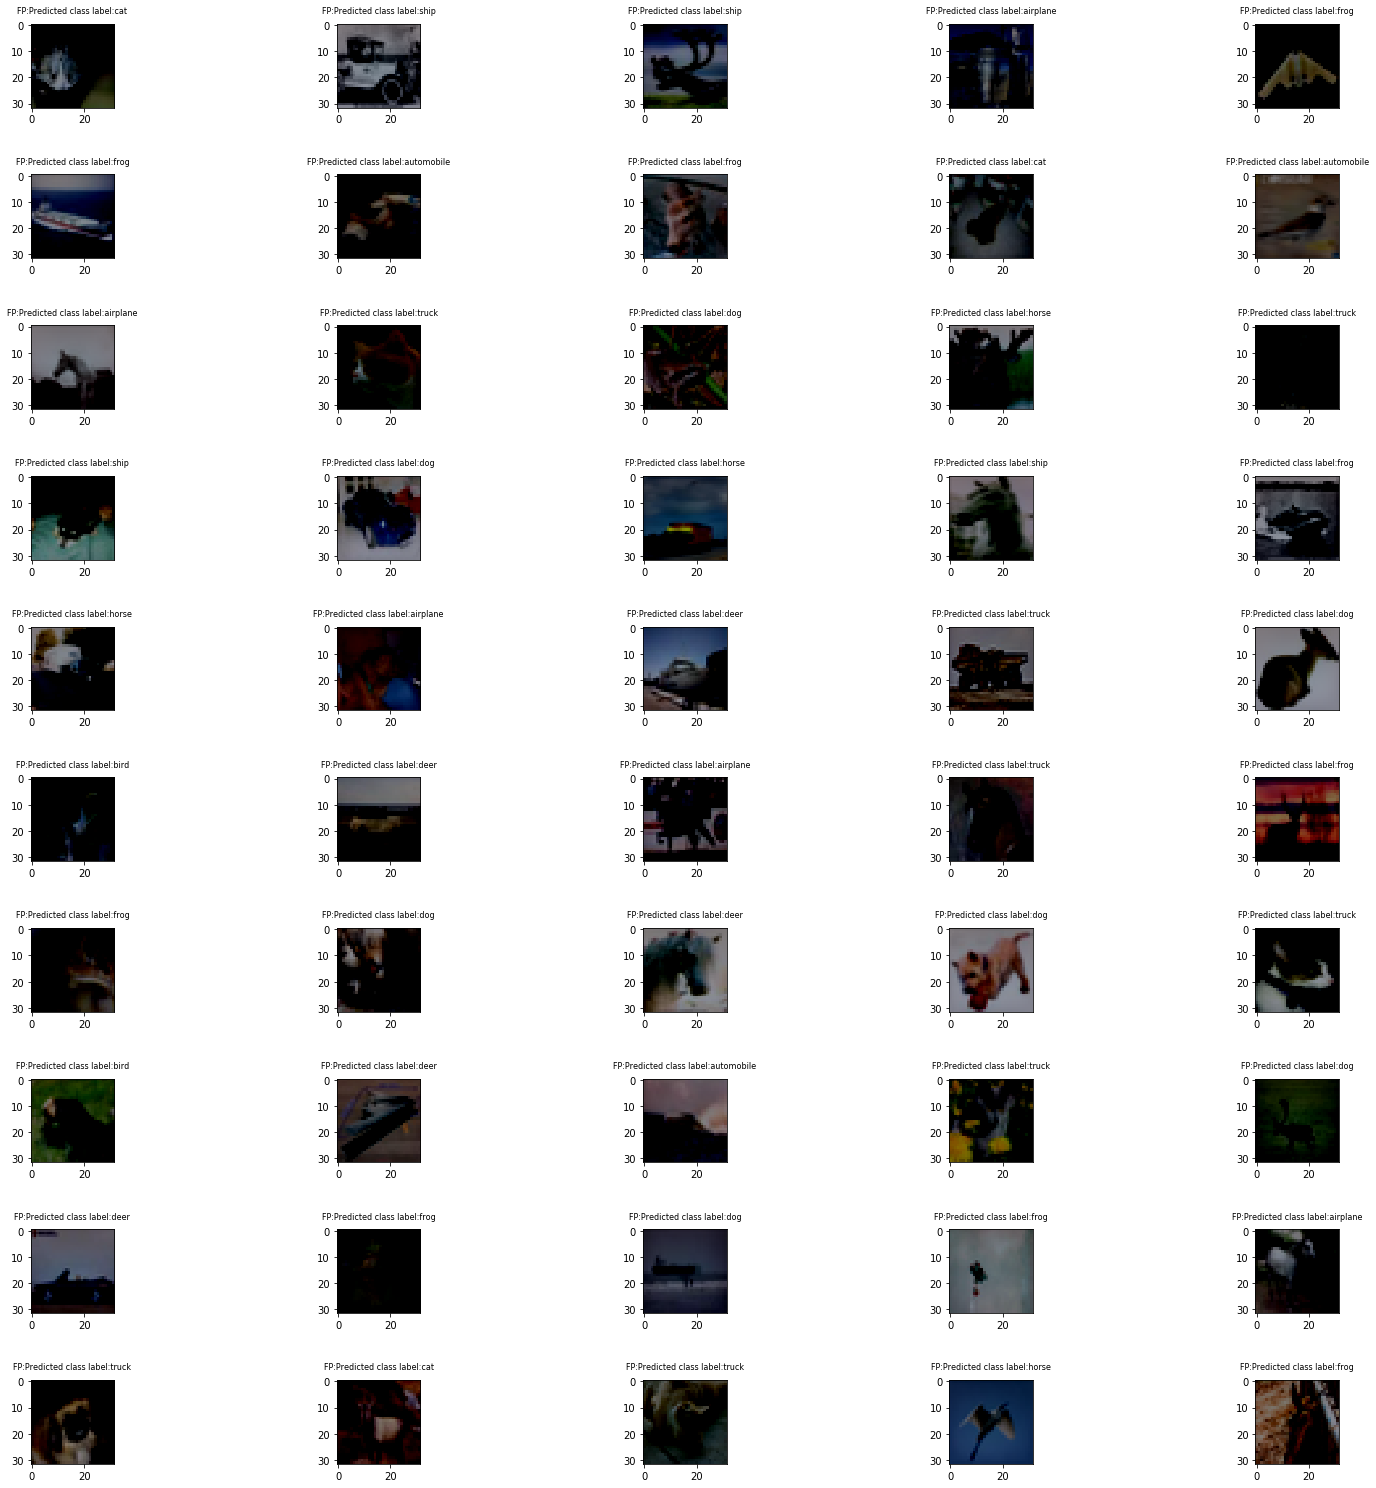

In [207]:
import sys
from matplotlib import pyplot as plt
%matplotlib inline
label_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
# Import packages for gradCAM
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
from google.colab.patches import cv2_imshow

# Plot missclassified Images

left = 0.125  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.1  # the bottom of the subplots of the figure
top = 0.9     # the top of the subplots of the figure
wspace = 0.8  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.8  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
plt.figure(figsize=(25,25))
for index, (image, label) in enumerate(zip(x_test[incorrect_imgs_50], y_test[incorrect_imgs_50])):
  plt.subplot(10, 5, (index + 1))
  
  t = y_test[index]
  lbl = label_names[np.argmax(t)] 
  
  plt.title('FP:Predicted class label:%s\n' % lbl, fontsize = 8, pad=0.1 )
  plt.imshow( image)
  plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

#### gradCAM Implementation for mis-classified Images.

In [0]:
# Import packages for gradCAM
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

In [0]:
# Loading data from cifar10 data set
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

False Positive: Model Predicted Class Label:cat 


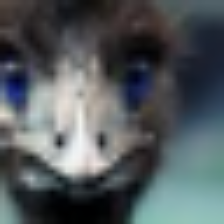

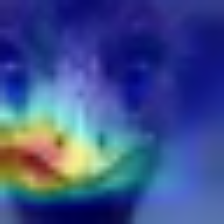

False Positive: Model Predicted Class Label:ship 


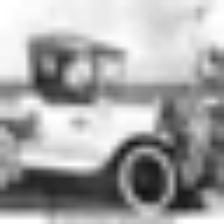

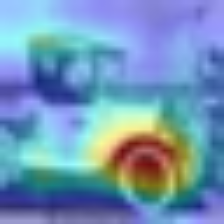

False Positive: Model Predicted Class Label:ship 


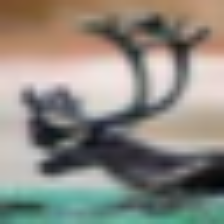

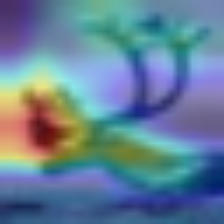

False Positive: Model Predicted Class Label:airplane 


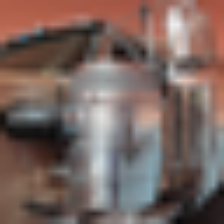

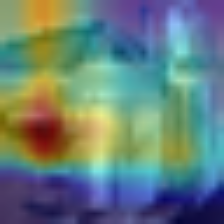

False Positive: Model Predicted Class Label:frog 


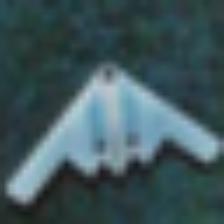

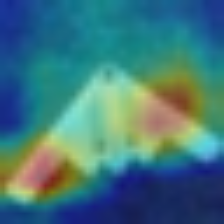

False Positive: Model Predicted Class Label:frog 


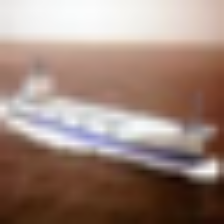

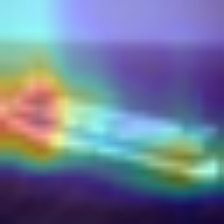

False Positive: Model Predicted Class Label:automobile 


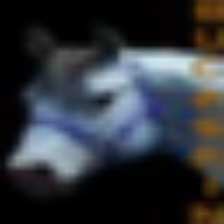

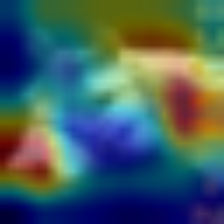

False Positive: Model Predicted Class Label:frog 


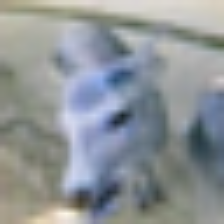

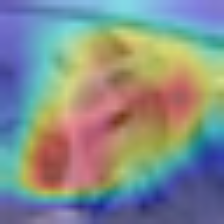

False Positive: Model Predicted Class Label:cat 


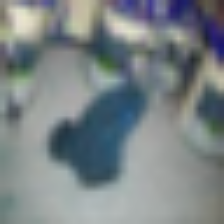

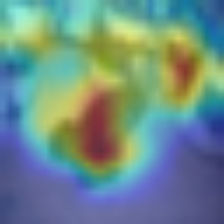

False Positive: Model Predicted Class Label:automobile 


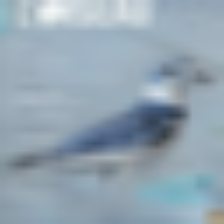

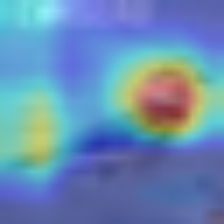

False Positive: Model Predicted Class Label:airplane 


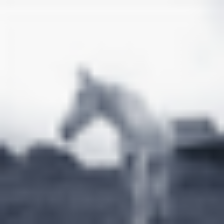

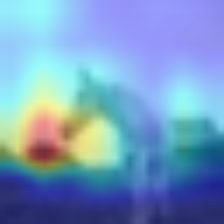

False Positive: Model Predicted Class Label:truck 


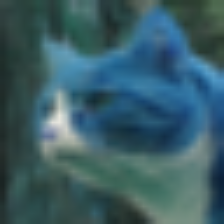

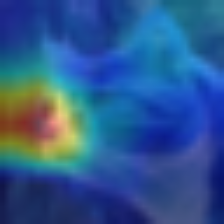

False Positive: Model Predicted Class Label:dog 


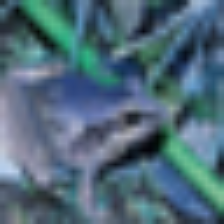

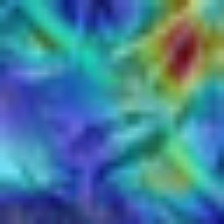

False Positive: Model Predicted Class Label:horse 


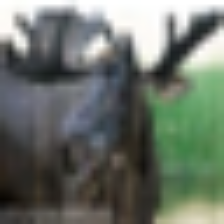

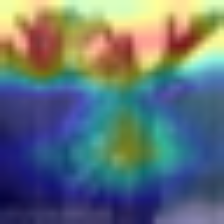

False Positive: Model Predicted Class Label:truck 


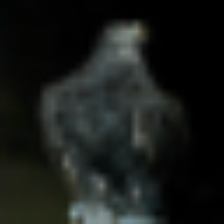

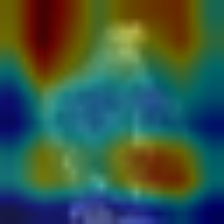

False Positive: Model Predicted Class Label:ship 


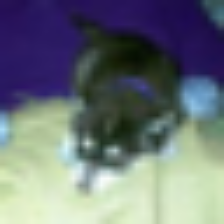

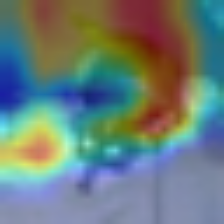

False Positive: Model Predicted Class Label:dog 


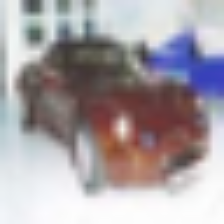

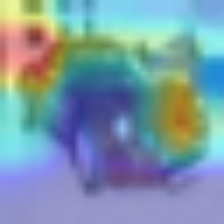

False Positive: Model Predicted Class Label:horse 


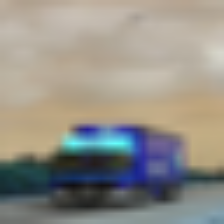

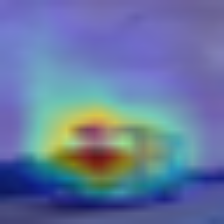

False Positive: Model Predicted Class Label:ship 


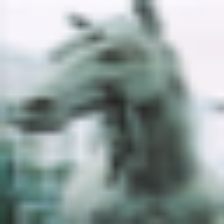

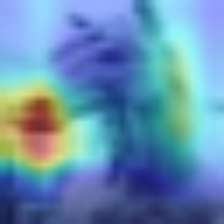

False Positive: Model Predicted Class Label:frog 


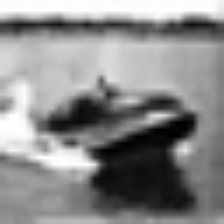

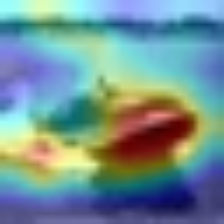

False Positive: Model Predicted Class Label:horse 


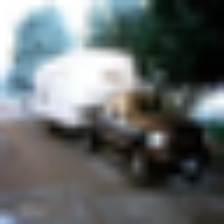

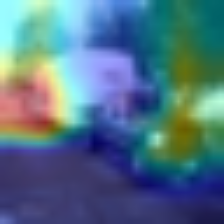

False Positive: Model Predicted Class Label:airplane 


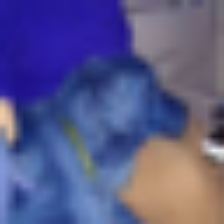

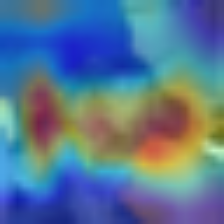

False Positive: Model Predicted Class Label:deer 


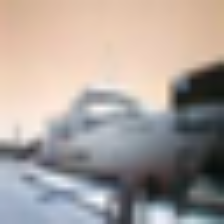

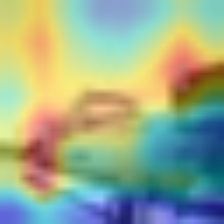

False Positive: Model Predicted Class Label:truck 


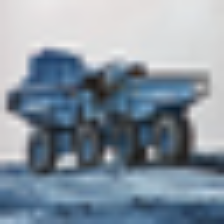

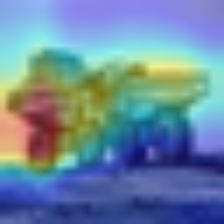

False Positive: Model Predicted Class Label:dog 


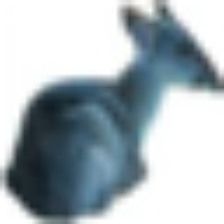

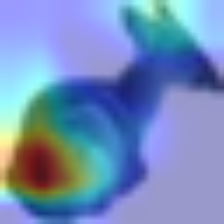

False Positive: Model Predicted Class Label:bird 


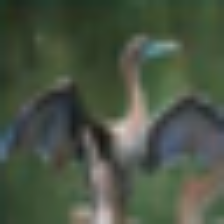

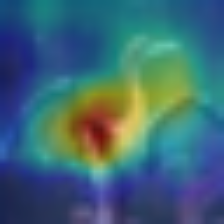

False Positive: Model Predicted Class Label:deer 


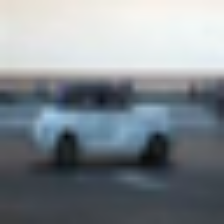

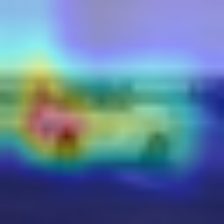

False Positive: Model Predicted Class Label:airplane 


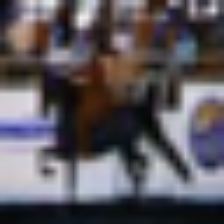

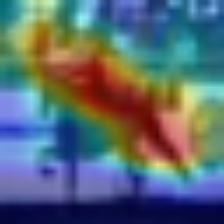

False Positive: Model Predicted Class Label:truck 


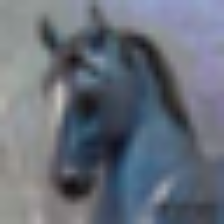

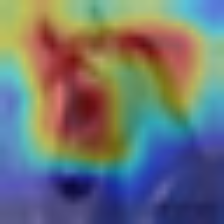

False Positive: Model Predicted Class Label:frog 


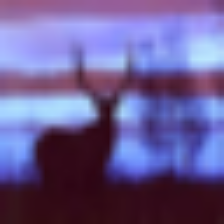

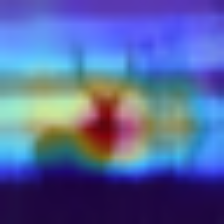

False Positive: Model Predicted Class Label:frog 


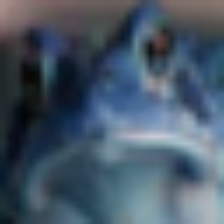

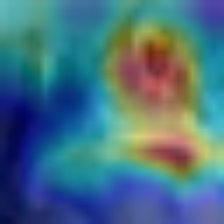

False Positive: Model Predicted Class Label:dog 


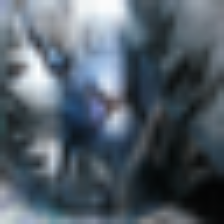

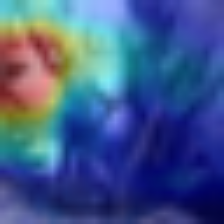

False Positive: Model Predicted Class Label:deer 


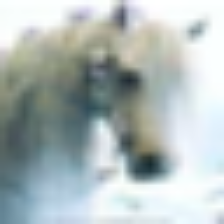

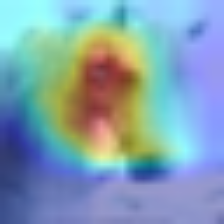

False Positive: Model Predicted Class Label:dog 


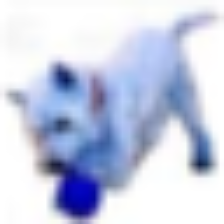

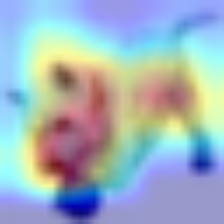

False Positive: Model Predicted Class Label:truck 


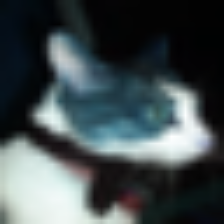

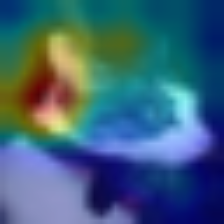

False Positive: Model Predicted Class Label:bird 


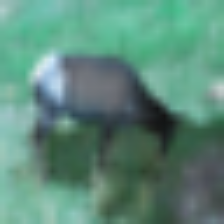

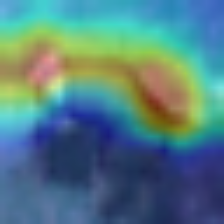

False Positive: Model Predicted Class Label:deer 


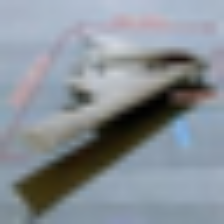

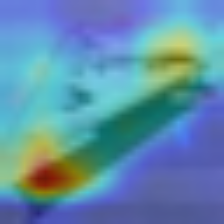

False Positive: Model Predicted Class Label:automobile 


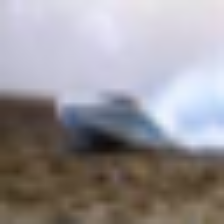

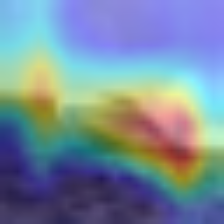

False Positive: Model Predicted Class Label:truck 


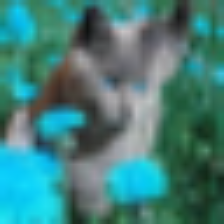

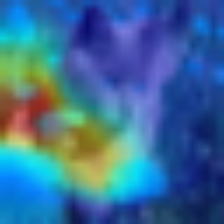

False Positive: Model Predicted Class Label:dog 


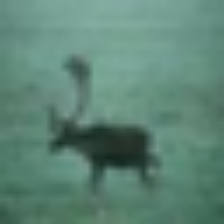

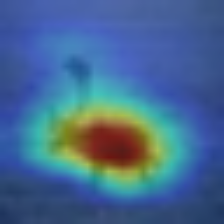

False Positive: Model Predicted Class Label:deer 


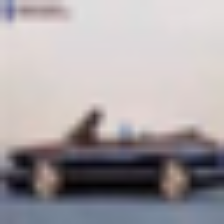

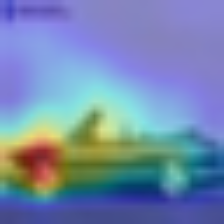

False Positive: Model Predicted Class Label:frog 


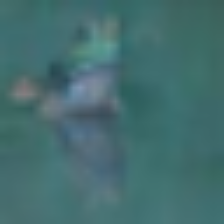

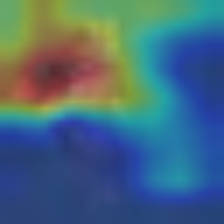

False Positive: Model Predicted Class Label:dog 


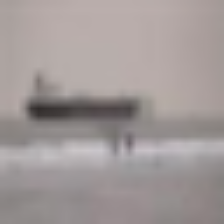

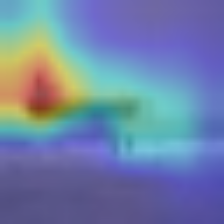

False Positive: Model Predicted Class Label:frog 


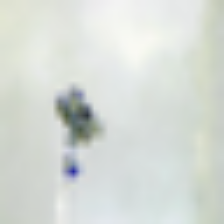

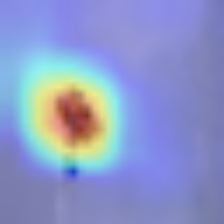

False Positive: Model Predicted Class Label:airplane 


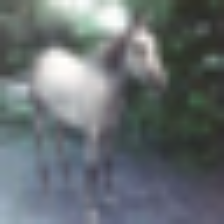

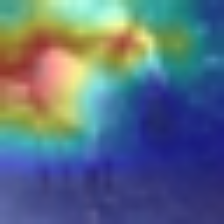

False Positive: Model Predicted Class Label:truck 


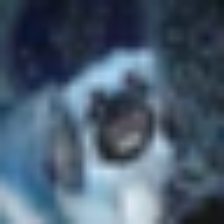

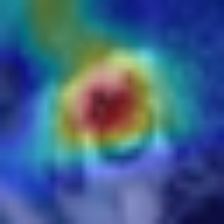

False Positive: Model Predicted Class Label:cat 


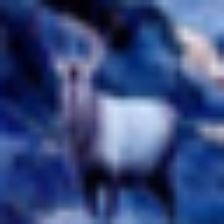

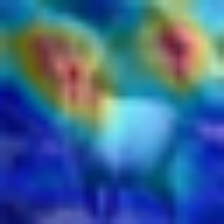

False Positive: Model Predicted Class Label:truck 


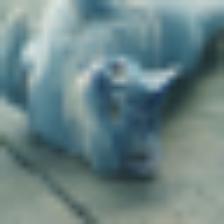

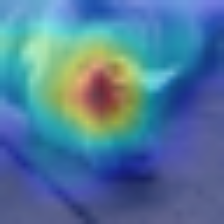

False Positive: Model Predicted Class Label:horse 


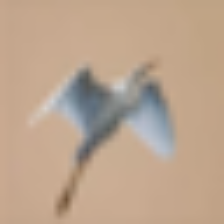

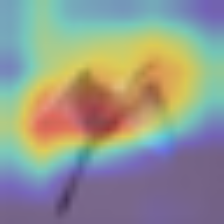

False Positive: Model Predicted Class Label:frog 


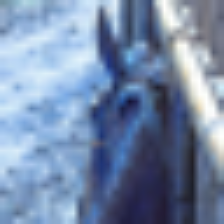

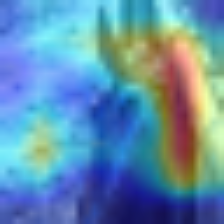

In [205]:
# Define cifar10 labels
label_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# cv2.imshow() is deprecated/crashed in jupyter, I used cv2_imshow() fro colab
from google.colab.patches import cv2_imshow

gradcam_test_features = test_features[incorrect_imgs_50]

for idx in range(50):
  img = gradcam_test_features[idx]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  
  
  last_conv_layer = model.get_layer("conv2d_42")
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
  print("False Positive: Model Predicted Class Label:%s "%(label_names[test_labels[idx][0]]))
  # Resizing test image samples and superimposed image samples from 32,32,3 to 128,128,3
  large_img = new_image = cv2.resize(img,(224,224))
  cv2_imshow(large_img)
  large_superimposed_img = cv2.resize(superimposed_img,(224,224))
  cv2_imshow(large_superimposed_img) 
  